In [1]:
%cd /data/codes/apa/train

from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import torch
import json
import os
import re

from src.dataset import (
    IndexedDataset,
    IndexedDatasetBuilder
)

/data/codes/apa/train


In [2]:
def map_phone(phones):
    mapped_phone = []
    for phone in phones:
        if phone == "SCHWA" or phone == "AH0":
            mapped_phone.append("AX")
        else:
            mapped_phone.append(phone)
    
    return mapped_phone

def get_phone_pure(phones):
    pure_phones = [re.sub(r"\d", "", phone) for phone in phones]

    return pure_phones

def preprocess_metadata(metadata):
    metadata = metadata[
        ["id", "audio_path", "text", "arpas", "trans", "phone_scores", "word_scores", "word_ids", "utterance_score", "fluency_score", "intonation_score"]
    ]
    metadata["id"] = metadata.id.apply(str)
    metadata = metadata.rename(columns={"arpas":"elsa_phone"})
    metadata["elsa_phone"] = metadata.elsa_phone.apply(map_phone)
    metadata["elsa_phone"] = metadata.elsa_phone.apply(get_phone_pure)
    metadata["trans"] = metadata.trans.apply(map_phone)

    return metadata

def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        lines = [json.loads(line.strip()) for line in lines]
    
    lines = pd.DataFrame(lines)
    return lines

def load_gops(gop_paths):
    gops = {}
    for path in gop_paths:
        try:
            gop = pickle.load(open(path, "rb"))
        except:
            continue
        
        for key in gop.keys():
            assert key not in gops

        gops.update(gop)

    return gops

In [3]:
metadata_path = "/data/codes/apa/train/data/metadata/jsonl/train-data-type-12.jsonl"
out_dir = "/data/codes/apa/train/data/feats/train/train-data-type-12-filtered"
data_dir = "/data/codes/apa/train/data/train/train-data-type-12"

metadata = load_jsonl(metadata_path)
metadata = preprocess_metadata(metadata)
print(metadata.shape)
metadata.head(1)

/tmp/ipykernel_2732687/4032995754.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["id"] = metadata.id.apply(str)


(81731, 11)


,id,audio_path,text,elsa_phone,trans,phone_scores,word_scores,word_ids,utterance_score,fluency_score,intonation_score
0,3487285,/data/audio_data/prep_submission_audio/12/3487...,A BUSY TONE,"[AX, B, IH, Z, IY, T, OW, N]","[AX, B, IH, Z, IY, T, OW, N]","[100, 78, 28.999999999999996, 94, 82, 96, 38, 33]","[94, 63, 45]","[0, 1, 1, 1, 1, 2, 2, 2]",57.07,0,0


<Axes: >

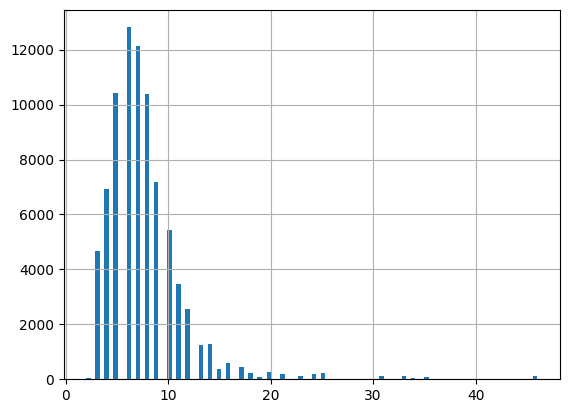

In [4]:
lengths = metadata["elsa_phone"].apply(len)
lengths.hist(bins=100)

In [5]:
MAX_LENGTH = 128

print(metadata.shape)
metadata = metadata[lengths<MAX_LENGTH-3]
print(metadata.shape)

(81731, 11)
(81731, 11)


In [6]:
if out_dir.endswith("-filtered"):
    id_path = f"{out_dir}/id"

    id_df = pd.read_csv(id_path, names=["id"], dtype={'id':str})
    id_df = id_df.set_index("id")

    print(metadata.shape)
    metadata = metadata[metadata.id.isin(id_df.index)]
    print(metadata.shape)

(81731, 11)
(35200, 11)


In [7]:
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
gop_path = f'{data_dir}/*/gop.pkl'
align_path = f'{data_dir}/*/ali.out'

alignment_paths = glob(align_path)
gop_paths = glob(gop_path)

In [8]:
def load_alignment(path):
    alignment_df = pd.read_csv(
        path, names=["id", "alignment"], sep="\t", dtype={"id": str}
    )
    alignment_df["alignment"] = alignment_df.alignment.apply(json.loads)

    return alignment_df

def load_alignments(paths):
    alignments = []
    for path in paths:
        alignment = load_alignment(path)
        alignments.append(alignment)
    
    alignments = pd.concat(alignments)
    alignments.reset_index(inplace=True)

    return alignments[["id", "alignment"]]

alignments = load_alignments(alignment_paths)
gops = load_gops(gop_paths)

In [9]:
is_valid = alignments.id.apply(lambda x: x in gops)
print(alignments.shape)
alignments = alignments[is_valid]
print(alignments.shape)

(81720, 2)
(81720, 2)


In [10]:
def extract_phonemes(alignments):
    phonemes = [
        re.sub("\d", "",phoneme[0].split("_")[0]) for phoneme in alignments
        if phoneme[0] != "SIL"
    ]
    return phonemes

def extract_durations(alignments):
    durations = [
        round(phoneme[2] * 0.02, 4) for phoneme in alignments
        if phoneme[0] != "SIL"
    ]
    return durations

def extract_relative_positions(alignments):
    relative_positions = [
        phoneme[0].split("_")[-1] for phoneme in alignments
        if phoneme[0] != "SIL"
    ]
    return relative_positions


alignments["relative_positions"] = alignments.alignment.apply(lambda x: extract_relative_positions(x))
alignments["prep_phone"] = alignments.alignment.apply(lambda x: extract_phonemes(x))
alignments["duration"] = alignments.alignment.apply(lambda x: extract_durations(x))

In [11]:
metadata = pd.merge(
    left=metadata, 
    right=alignments[["id", "alignment", "prep_phone", "relative_positions", "duration"]], 
    how="inner", on="id"
)

metadata.head(1)

,id,audio_path,text,elsa_phone,trans,phone_scores,word_scores,word_ids,utterance_score,fluency_score,intonation_score,alignment,prep_phone,relative_positions,duration
0,5431111,/data/audio_data/prep_submission_audio/12/5431...,A BUSY TONE,"[AX, B, IH, Z, IY, T, OW, N]","[AX, B, IH, Z, IY, T, OW, N]","[100, 82, 84, 99, 89, 96, 84, 95]","[100, 89, 92]","[0, 1, 1, 1, 1, 2, 2, 2]",91.56,0,0,"[[SIL, 0, 61], [AX_S, 61, 7], [B_B, 68, 12], [...","[AX, B, IH, Z, IY, T, OW, N]","[S, B, I, I, E, B, I, E]","[0.14, 0.24, 0.3, 0.18, 0.18, 0.22, 0.28, 0.3]"


In [12]:
def count_match(elsa, prep, scores):
    for index, (phone_1, phone_2) in enumerate(zip(elsa, prep)):
        if phone_1 != phone_2:
            if scores[index] < 40:
                continue
            return 0
        
    return 1

is_matched = metadata.apply(lambda x: count_match(elsa=x["elsa_phone"], prep=x["prep_phone"], scores=x["phone_scores"]), axis=1)
metadata = metadata[is_matched==True]
print(is_matched.sum())
print(is_matched.shape)

35200
(35200,)


### Extract alignment

In [13]:
def preprocess_alignments(alignment):
    processed_alignment = []
    for phone, start, duration in alignment:
        if phone == "SIL":
            continue
        phone = phone.split("_")[0]
        processed_alignment.append([phone, start, duration])
    
    return processed_alignment

In [14]:
with open(f'{out_dir}/alignment', "w", encoding="utf-8") as f:
    for index in tqdm(metadata.index):
        _id = metadata["id"][index]
        _alignment = metadata["alignment"][index]

        _alignment = preprocess_alignments(_alignment)

        _alignment= json.dumps(_alignment, ensure_ascii=False)
        
        f.write(f'{_alignment}\n')

 35%|███▌      | 12320/35200 [00:00<00:00, 123194.54it/s]

100%|██████████| 35200/35200 [00:00<00:00, 128520.87it/s]


#### Extract audio_path

In [15]:
with open(f'{out_dir}/wav_path', "w", encoding="utf-8") as f:
    for index in tqdm(metadata.index):
        audio_path = metadata["audio_path"][index]
        
        f.write(f'{audio_path}\n')

100%|██████████| 35200/35200 [00:00<00:00, 527883.46it/s]


### Extract id

In [16]:
with open(f'{out_dir}/id', "w", encoding="utf-8") as f:
    for index in tqdm(metadata.index):
        _id = metadata["id"][index]
        
        f.write(f'{_id}\n')

100%|██████████| 35200/35200 [00:00<00:00, 513818.22it/s]


### Extract gop feature

In [17]:
indexed_path = f'{out_dir}/gop'

builder = IndexedDatasetBuilder(indexed_path)
for index in tqdm(metadata.index):
    _id = metadata["id"][index]
    gop = gops[_id]

    gop = np.array(gop)
    builder.add_item(item=gop)
    
builder.finalize()

100%|██████████| 35200/35200 [00:00<00:00, 125548.49it/s]


In [18]:
temp = IndexedDataset(indexed_path)
temp[0]

array([[-7.116742  , -6.182339  , -2.982992  , -3.1070542 , -3.192233  ,
        -3.6303632 , -4.1627593 , -2.3699126 , -3.388797  , -3.4089441 ,
        -5.0715685 , -3.6801481 , -4.675005  , -5.0659685 , -3.2166438 ,
        -2.9722505 , -3.4740481 , -4.3336525 , -4.440655  , -5.123091  ,
        -3.1438622 , -3.7903104 , -4.922741  , -4.0164466 , -3.590558  ,
        -3.463054  , -3.8957615 , -5.8194265 , -3.1367693 , -5.106355  ,
        -3.4862204 , -3.3716698 , -3.7946825 , -5.033477  , -3.7969842 ,
        -4.9770555 , -4.637282  , -4.0123873 , -3.9149091 , -4.714989  ,
        -4.772168  , -4.440412  , -6.6323647 , -4.7468295 , -3.8124266 ,
        -0.6130793 , -0.7371416 , -0.82232046, -1.2604506 , -1.7928467 ,
         0.        , -1.0188844 , -1.0390315 , -2.7016559 , -1.3102355 ,
        -2.3050923 , -2.696056  , -0.8467312 , -0.60233784, -1.1041355 ,
        -1.9637399 , -2.0707426 , -2.7531786 , -0.7739496 , -1.4203978 ,
        -2.5528283 , -1.646534  , -1.2206454 , -1.0

### Extract Relative Position

In [19]:
path = "/data/codes/apa/train/exp/dicts/relative2id.json"
relative2id = json.load(open(path, "r", encoding="utf-8"))

In [20]:
def convert_relative_position_to_id(relative_positions):
    ids = []
    for rel_pos in relative_positions:
        _id = relative2id[rel_pos]
        ids.append(_id)

    return ids
metadata["relative_positions"] = metadata["relative_positions"].apply(convert_relative_position_to_id)

In [21]:
indexed_path = f'{out_dir}/relative_positions'

builder = IndexedDatasetBuilder(indexed_path)

for index in metadata.index:
    relative_position = metadata["relative_positions"][index].copy()

    relative_position = np.array(relative_position)

    builder.add_item(item=relative_position)
builder.finalize()

In [22]:
indexed_path = f'{out_dir}/relative_positions'
temp = IndexedDataset(indexed_path)
temp[0]

array([4, 1, 2, 2, 3, 1, 2, 3])

### Extract sentence scores

In [23]:
indexed_path = f'{out_dir}/sentence_scores'

builder = IndexedDatasetBuilder(indexed_path)
for index in metadata.index:
    sentence_score = metadata["utterance_score"][index].copy()

    builder.add_item(item=sentence_score)

builder.finalize()

In [24]:
indexed_path = f'{out_dir}/sentence_scores'
temp = IndexedDataset(indexed_path)
temp[0]

91.56

### Extract fluency scores

In [25]:
indexed_path = f'{out_dir}/fluency_score'

builder = IndexedDatasetBuilder(indexed_path)
for index in metadata.index:
    sentence_score = metadata["utterance_score"][index].copy()

    builder.add_item(item=sentence_score)

builder.finalize()

In [26]:
indexed_path = f'{out_dir}/fluency_score'
temp = IndexedDataset(indexed_path)
temp[0]

91.56

#### Extract intonation score 

In [27]:
indexed_path = f'{out_dir}/intonation_score'

builder = IndexedDatasetBuilder(indexed_path)
for index in metadata.index:
    sentence_score = metadata["utterance_score"][index].copy()

    builder.add_item(item=sentence_score)

builder.finalize()

In [28]:
indexed_path = f'{out_dir}/intonation_score'
temp = IndexedDataset(indexed_path)
temp[0]

91.56

### Extract word scores

In [29]:
indexed_path = f'{out_dir}/word_scores'

builder = IndexedDatasetBuilder(indexed_path)
for index in metadata.index:
    word_score = metadata["word_scores"][index].copy()
    word_id = metadata["word_ids"][index].copy()

    word_score_in_phone_levels = []
    for wid in word_id:
        word_score_in_phone_levels.append(word_score[wid])

    word_score_in_phone_levels = np.array(word_score_in_phone_levels)
    builder.add_item(item=word_score_in_phone_levels)

builder.finalize()

In [30]:
indexed_path = f'{out_dir}/word_scores'
temp = IndexedDataset(indexed_path)
temp[0]

array([100,  89,  89,  89,  89,  92,  92,  92])

### Extract word ids

In [31]:
indexed_path = f'{out_dir}/word_ids'

builder = IndexedDatasetBuilder(indexed_path)
for index in metadata.index:
    word_id = metadata["word_ids"][index].copy()

    word_id = np.array(word_id)
    builder.add_item(item=word_id)

builder.finalize()

In [32]:
indexed_path = f'{out_dir}/word_ids'
temp = IndexedDataset(indexed_path)
temp[0]

array([0, 1, 1, 1, 1, 2, 2, 2])

### Extract duration feature

In [33]:
indexed_path = f'{out_dir}/duration'

builder = IndexedDatasetBuilder(indexed_path)
for index in metadata.index:
    duration = metadata["duration"][index].copy()

    duration = np.array(duration)
    builder.add_item(item=duration)

builder.finalize()

In [34]:
indexed_path = f'{out_dir}/duration'
temp = IndexedDataset(indexed_path)
temp[0]

array([0.14, 0.24, 0.3 , 0.18, 0.18, 0.22, 0.28, 0.3 ])

### Extract phone scores

In [35]:
indexed_path = f'{out_dir}/phone_scores'

builder = IndexedDatasetBuilder(indexed_path)
for index in metadata.index:
    phone_score = metadata["phone_scores"][index].copy()

    phone_score = np.array(phone_score)
    builder.add_item(item=phone_score)

builder.finalize()

In [36]:
indexed_path = f'{out_dir}/phone_scores'
temp = IndexedDataset(indexed_path)
temp[0]

array([100,  82,  84,  99,  89,  96,  84,  95])

### Extract phone ids

In [37]:
phone_dict_path =  "/data/codes/apa/train/exp/dicts/phone_dict.json"
with open(phone_dict_path, "r", encoding="utf-8") as f:
    phone_dict = json.load(f)

In [38]:
indexed_path = f'{out_dir}/phone_ids'

builder = IndexedDatasetBuilder(indexed_path)
for index in metadata.index:
    phoneme = metadata["elsa_phone"][index].copy()

    phoneme = [re.sub("\d", "", phn) for phn in phoneme]
    phoneme = [phone_dict[phn] for phn in phoneme]

    phoneme = np.array(phoneme)
    builder.add_item(item=phoneme)

builder.finalize()

In [39]:
indexed_path = f'{out_dir}/phone_ids'
temp = IndexedDataset(indexed_path)
temp[0]

array([ 3,  8, 18, 38, 19, 31, 26, 24])

### Extract WavLM Feature

In [40]:
import torch
from src.models.wavlm_model import WavLM, WavLMConfig
from tqdm import tqdm
import librosa
import pandas as pd
import json

In [41]:
pretrained_path = "/data/codes/apa/train/exp/torch/wavlm-base+.pt"
checkpoint = torch.load(pretrained_path)

config = WavLMConfig(checkpoint['cfg'])
model = WavLM(config).eval().cuda()
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [42]:
def extract_feature(alignment, features):
    index = 0
    phonemes = []
    indices = -1 * torch.ones(alignment[-1][1] + alignment[-1][2])
    for phoneme, start_frame, duration in alignment:
        if phoneme == "SIL":
            continue
        end_frame = start_frame + duration
        indices[start_frame:end_frame] = index
        phonemes.append(phoneme)
        index += 1

    if -1 in indices:
        indices[indices==-1] = indices.max() + 1

        indices = torch.nn.functional.one_hot(indices.long(), num_classes=int(indices.max().item())+1).cuda()
        indices = indices / indices.sum(0, keepdim=True)
    
        if features.shape[0] != indices.shape[0]:
            features = features[0:indices.shape[0]]
        features = torch.matmul(indices.transpose(0, 1), features)

        return features[:-1].cpu(), phonemes
    
    else:
        indices[indices==-1] = indices.max() + 1

        indices = torch.nn.functional.one_hot(indices.long(), num_classes=int(indices.max().item())+1).cuda()
        indices = indices / indices.sum(0, keepdim=True)
    
        if features.shape[0] != indices.shape[0]:
            features = features[0:indices.shape[0]]
        features = torch.matmul(indices.transpose(0, 1), features)

        return features.cpu(), phonemes

In [43]:
indexed_path = f'{out_dir}/wavlm_features'
builder = IndexedDatasetBuilder(indexed_path)

wavlm_features = []
for index in tqdm(metadata.index):
    audio_path = metadata["audio_path"][index]
    alignment = metadata["alignment"][index]

    wav, sr = librosa.load(audio_path, sr=16000)

    input_values = torch.from_numpy(wav).unsqueeze(0).cuda()
    with torch.no_grad():
        features = model.extract_features(input_values)[0]
        if index % 1000:
            torch.cuda.empty_cache()

    index = torch.arange(features.shape[1]).unsqueeze(-1)
    expanded_index = index.expand((-1, 2)).flatten()
    features = features[0][expanded_index]

    features, phonemes = extract_feature(alignment, features)
    if len(features) != len(phonemes):
        print(metadata["id"][index])

    builder.add_item(item=features.numpy())

builder.finalize()

100%|██████████| 35200/35200 [04:10<00:00, 140.36it/s]


In [44]:
indexed_path = f'{out_dir}/wavlm_features'
temp = IndexedDataset(indexed_path)
temp[0]

array([[ 0.08130476,  0.07263201, -0.07608949, ..., -0.00783878,
        -0.03720406,  1.4098275 ],
       [-0.13576174,  0.04174832, -0.02789874, ..., -0.09399985,
        -0.05584437, -0.02282273],
       [-0.07156481,  0.00598408,  0.06466427, ...,  0.04812061,
        -0.01696148, -0.06876357],
       ...,
       [-0.02474039,  0.06198201,  0.04122187, ..., -0.08150275,
         0.08054809,  0.33946952],
       [ 0.04388144, -0.07911746,  0.03561262, ...,  0.03619873,
         0.03484895,  1.4967892 ],
       [ 0.01328066, -0.04392435, -0.14953792, ...,  0.05542174,
        -0.05408154,  0.83228636]], dtype=float32)